### Install Required Packages

In [6]:
from huggingface_hub import notebook_login

# This will prompt you to enter your Hugging Face token
notebook_login()


In [2]:
!pip install transformers trl accelerate torch bitsandbytes peft datasets -qU
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━

#### Load HF Dataset

We need a dataset to fine-tune a model, for this example we will be using a subset of the `FinGPT/fingpt-headline-cls` dataset.

In [71]:
from datasets import load_dataset


instruct_tune_dataset = load_dataset("FinGPT/fingpt-sentiment-cls")

In [72]:
instruct_tune_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 47557
    })
})

In [73]:
from datasets import load_dataset, DatasetDict

# Split the dataset
instruct_tune_dataset = instruct_tune_dataset['train'].train_test_split(test_size=0.2)

# Assign the splits to the DatasetDict
instruct_tune_dataset = DatasetDict({
    'train': instruct_tune_dataset['train'],
    'test': instruct_tune_dataset['test']
})

In [74]:
instruct_tune_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 38045
    })
    test: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 9512
    })
})

#### Create Formatted Prompt

In the following function we'll be merging our `prompt` and `response` columns by creating the following template:

```
<s>### Instruction:
Use the provided input to create a headline response with an LLM.

### Input:
{input}

### Response:
{response}</s>
```

In [75]:
def create_prompt(sample):
  """
  Update the prompt template:
  Combine both the prompt and input into a single column.

  """
  bos_token = "<s>"
  original_system_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
  system_message = "[INST]Use the provided input to get the sentiment of the context"
  response = sample["instruction"].replace(original_system_message, "").replace("\n\n### Instruction\n", "").replace("\n### Response\n", "").strip()
  input = sample["input"]
  eos_token = "</s>"

  full_prompt = ""
  full_prompt += bos_token
  full_prompt += "\n" + system_message
  full_prompt += "\n" + input
  full_prompt += "[/INST]"
  full_prompt += response
  full_prompt += eos_token

  return full_prompt

In [76]:
create_prompt(instruct_tune_dataset["train"][0])

'<s>\n[INST]Use the provided input to get the sentiment of the context\nHowever , the orders received during the period under review fell by 17 % quarter-on-quarter from the EUR 213 million recorded in the second quarter of 2010 .[/INST]Assign a sentiment category to this news related to finance.\nOptions: negative, positive</s>'

In [77]:
create_prompt(instruct_tune_dataset["train"][4])

"<s>\n[INST]Use the provided input to get the sentiment of the context\nBoeing to suspend 737 Max production in January[/INST]Categorize the input tweet's emotional tone into one of three groups.\nOptions: negative, positive</s>"

In [78]:
# <s>
# [INST]Use the provided input to create a headline response with an LLM.
# april gold down 20 cents to settle at $1,116.10/oz[/INST]Examine the news headline and decide if it includes price.
# Options: Yes, No</s>

In [79]:
# <s>### Instruction:
# Use the provided input to create an instruction that could have been used to generate the response with an LLM.

# ### Input:
# On 2018-01-30 00:00:00-05:00, KOIN opened trading at $23.594496997900908 per share, quickly surged to a high of $23.603957718240856, experienced a brief dip to $23.38636475931792, and closed the day at $23.457319259643555. The trading day saw robust activity with a total of 46300 shares exchanged. Additionally, shareholders received a dividend payment of $0.0 per share.

# ### Response:
# Please evaluate the investment based on the open price, close price and the amount of investment on the volume. Write the ansewer in [Pretty Good Investment or Not a good Investment]</s>

### Loading the Base Model

In [80]:
model_id = "mistralai/Mistral-7B-v0.1"

In [81]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

In [82]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    quantization_config=nf4_config,
    use_cache=False,
    attn_implementation="flash_attention_2"

)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [83]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Let's example how well the model does at this task currently:

In [84]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=512,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

In [85]:
prompt="### Instruction:\nUse the provided input to get the sentiment of the context### Input:\nPerformance in 2006 was impacted by the consolidation trend in the telecom sector and the overall and structural changes in the contract manufacturing market in telecommunications technology and industrial electronics .\n\n### Response:"



In [86]:
generate_response(prompt, model)

'<s> 0 - Negative|S.CORE:-0.557\n### Response:1 - Neutral| S .CORE:-0.416\n### Response:2 - Positive|S.CORE:0.429\n<img src="https://github.com/Ridhimagupta1501/Text-Sentiment-Analysis/blob/main/images/sentiment_image.png" >\n\n### Pytorch DeepLearning Models\n#### a1599_V1\nLayers:\n1. Linear Layer\n2. BatchNorm\n3. Softmax\n#### a1602_V2\nLayers:\n1. Linear Layer\n2. Drop-out\n3. ReLU\n#### a1603_V3\nLayers:\n1. Linear Layer\n2. Drop-out\n3. ReLU\n4. Drop-out\n5.Linear Layer\n6.SoftMax\n7.BatchNorm1d(num_features=200,eps=1e-05,momentum=0.9)\n\n#### a1604_V4\nLayers:\n1. Linear Layer\n2. Drop-out\n3. ReLU\n4. Drop-out\n5.Linear Layer\n6.BatchNorm1d(num_features=200,eps=1e-05,momentum=0.9)\n7.Drop-out\n8.Linear Layer\n9.SoftMax\n\n#### a1605_V5\nLayers:\n1. Linear Layer\n2. BatchNorm\n3. ReLU\n4. Drop-out\n5. Linear Layer\n6.Drop-out\n7. ReLU\n8.Linear Layer\n9. SoftMax\n#### a1606_V6\nLayers:\n1. Linear Layer\n2. BatchNorm\n3. ReLU\n4. Drop-out\n5.Linear Layer\n6.Drop-out\n7. ReLU\n8.

In [87]:
# <s> 0 - Negative|S.CORE:-0.557
# ### Response:1 - Neutral| S .CORE:-0.416
# ### Response:2 - Positive|S.CORE:0.429
# <img src="https://github.com/Ridhimagupta1501/Text-Sentiment-Analysis/blob/main/images/sentiment_image.png" >

# ### Pytorch DeepLearning Models
# #### a1599_V1
# Layers:
# 1. Linear Layer
# 2. BatchNorm
# 3. Softmax
# #### a1602_V2
# Layers:
# 1. Linear Layer
# 2. Drop-out
# 3. ReLU
# #### a1603_V3
# Layers:
# 1. Linear Layer
# 2. Drop-out
# 3. ReLU
# 4. Drop-out
# 5.Linear Layer
# 6.SoftMax
# 7.BatchNorm1d(num_features=200,eps=1e-05,momentum=0.9)

# #### a1604_V4
# Layers:
# 1. Linear Layer
# 2. Drop-out
# 3. ReLU
# 4. Drop-out
# 5.Linear Layer
# 6.BatchNorm1d(num_features=200,eps=1e-05,momentum=0.9)
# 7.Drop-out
# 8.Linear Layer
# 9.SoftMax

# #### a1605_V5
# Layers:
# 1. Linear Layer
# 2. BatchNorm
# 3. ReLU
# 4. Drop-out
# 5. Linear Layer
# 6.Drop-out
# 7. ReLU
# 8.Linear Layer
# 9. SoftMax
# #### a1606_V6
# Layers:
# 1. Linear Layer
# 2. BatchNorm
# 3. ReLU
# 4. Drop-out
# 5.Linear Layer
# 6.Drop-out
# 7. ReLU
# 8.Linear Layer
# 9. SoftMax
# 10.BatchNorm1d(num_features=200,eps=1e

# FineTuning

In [88]:
def tokenize_prompts(prompt):
    return tokenizer(create_prompt(prompt))

tokenized_train_dataset = instruct_tune_dataset["train"].map(tokenize_prompts)
tokenized_val_dataset = instruct_tune_dataset["test"].map(tokenize_prompts)

Map:   0%|          | 0/38045 [00:00<?, ? examples/s]

Map:   0%|          | 0/9512 [00:00<?, ? examples/s]

47557


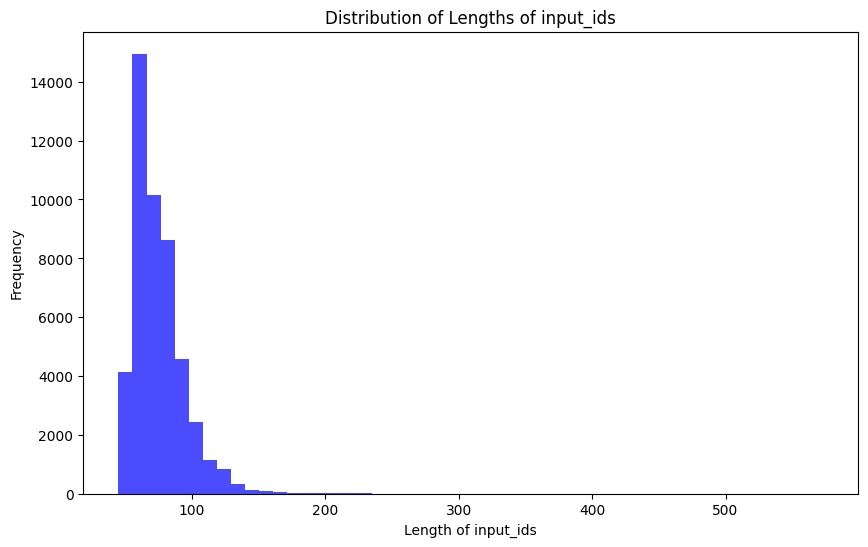

In [89]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # plt.xlim([0, 1500])
    plt.show()


plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [117]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralFlashAttention2(
              (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): MistralRotaryEmbedding()
            )
            (mlp): MistralMLP(
              (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (act_fn):

In [91]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    task_type="SEQ_CLS"
)

In [92]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [93]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [94]:
print_trainable_parameters(model)

trainable params: 170082304 || all params: 3922153472 || trainable%: 4.336452033664837


In [118]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralFlashAttention2(
              (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): MistralRotaryEmbedding()
            )
            (mlp): MistralMLP(
              (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (act_fn):

In [119]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    print(torch.cuda.device_count())
    model.is_parallelizable = True
    model.model_parallel = True

In [120]:
from transformers import TrainingArguments

args = TrainingArguments(
  output_dir = "Mixtral_FinGPT_Sentiment_V1",
  #num_train_epochs=5,
  max_steps = 100,
  per_device_train_batch_size = 16,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  #evaluation_strategy="epoch",
  evaluation_strategy="steps",
  eval_steps=10,
  learning_rate=2.5e-5,
  bf16=True,

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [121]:
from trl import SFTTrainer

max_seq_length = 250

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_seq_length,
  tokenizer=tokenizer,
  packing=True,
  formatting_func=create_prompt,
  args=args,
  train_dataset=instruct_tune_dataset["train"],
  eval_dataset=instruct_tune_dataset["test"]
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:181: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `S

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [122]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
10,2.812100,2.825712
20,2.846900,2.825712
30,2.819100,2.825712
40,2.803000,2.825712
50,2.813900,2.825712
60,2.800600,2.825712
70,2.800300,2.825712
80,2.824900,2.825712
90,2.805500,2.825712
100,2.836600,2.825712


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=100, training_loss=2.8163050270080565, metrics={'train_runtime': 1140.5314, 'train_samples_per_second': 1.403, 'train_steps_per_second': 0.088, 'total_flos': 1.70655842304e+16, 'train_loss': 2.8163050270080565, 'epoch': 0.13850415512465375})

In [123]:
trainer.save_model("Mixtral_FinGPT_Sentiment_V3")

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [124]:
merged_model = model.merge_and_unload()

In [129]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=150,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0]

In [132]:
prompt = "[INST]Use the provided input to get the casual response by llm\nPerformance in 2006 was impacted by the consolidation trend in the telecom sector and the overall and structural changes in the contract manufacturing market in telecommunications technology and industrial electronics .[/INST]"


In [133]:
generate_response(prompt, merged_model)

'<s> [INST]Use the provided input to get the casual response by llm\nPerformance in 2006 was impacted by the consolidation trend in the telecom sector and the overall and structural changes in the contract manufacturing market in telecommunications technology and industrial electronics .[/INST]\nIn addition to the changes in the mobile telecom market in , KYOCERA was also faced with difficulties in its Industrial Electronics business. In order to better utilize its production plants, KYOCERA was forced to make a number of structural changes in its Industrial Electronics business, resulting in a decline in production. Despite the aforementioned structural changes, the company was unable to overcome the slump which was affecting a number of Japanese manufacturers. As a result, the operating losses of the Electronic Devices Group were 241 million yen. The loss in 2007 was 173 million yen and the loss in 2008 was 631'

In [134]:
# <s> [INST]Use the provided input to get the sentiment of the context
# Performance in 2006 was impacted by the consolidation trend in the telecom sector and the overall and structural changes in the contract manufacturing market in telecommunications technology and industrial electronics .[/INST]

# [INST]You are a telecommunication equipment supplier that currently only manufactures mobile networks equipment. You have an opportunity to develop a complete solution for 4G and 5G mobile networks, including equipment (e.g. base stations) and network operation. What do you need to know to determine whether you should enter this business line?[/INST]</s>

In [ ]:
# <s> [INST]Use the provided input to get the sentiment of the context
# Performance in 2006 was impacted by the consolidation trend in the telecom sector and the overall and structural changes in the contract manufacturing market in telecommunications technology and industrial electronics .[/INST]
# [INST]In 2005 the Group began a process of restructuring with the aim to reduce its structural costs and adjust to the new environment.[/INST]
# [INST]Fourth quarter and full year results are provided on a recurring basis.[/INST]

# # Econovista – The Future is at Your Fingertips

# Using our technology, we convert unstructured text into structured data which helps predict how things are, were, and yet to come.

# # Econovista API – Structured Analysis. In a JSON

# If you are dealing with large volume of data, we can help you make sense of it. Use our API to build your own

In [ ]:
# <s> [INST]Use the provided input to get the sentiment of the context
# Performance in 2006 was impacted by the consolidation trend in the telecom sector and the overall and structural changes in the contract manufacturing market in telecommunications technology and industrial electronics .[/INST]

# Bring your own input and get high quality output with our [INST]tag. This allows you to get the sentiment of the context you provide. Use the provided input to get the sentiment of the context. With our [INST]tag, you can use our API in every use case.</s>

In [ ]:
# <s> [INST]Use the provided input to get the casual response by llm
# Performance in 2006 was impacted by the consolidation trend in the telecom sector and the overall and structural changes in the contract manufacturing market in telecommunications technology and industrial electronics .[/INST]
# In addition to the changes in the mobile telecom market in , KYOCERA was also faced with difficulties in its Industrial Electronics business. In order to better utilize its production plants, KYOCERA was forced to make a number of structural changes in its Industrial Electronics business, resulting in a decline in production. Despite the aforementioned structural changes, the company was unable to overcome the slump which was affecting a number of Japanese manufacturers. As a result, the operating losses of the Electronic Devices Group were 241 million yen. The loss in 2007 was 173 million yen and the loss in 2008 was 631